In [1]:
import pandas as pd
import numpy as np

from scipy import sparse

import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from keras.preprocessing.text import text_to_word_sequence
import pickle

import scispacy
import spacy
from scispacy.abbreviation import AbbreviationDetector
from spacy import displacy

Using TensorFlow backend.


In [2]:
#Reading the csv file
df = pd.read_csv('Epic.csv', encoding = "ISO-8859-1")
df

,id,enroll,contact_date,department_name,doc_name,NOTE,Alcohol Use,Amount,Alcohol Abuse Current,Alcohol Abuse Past,...,Type,Current Smoker,Former Smoker,Amount.1,NOTES/COMMENTS,Mention_any,Mention_alcohol_use,Mention_alcohol_abuse_curr,Mention_alcohol_abuse_past,Mention_current_drug_use
0,2642,ENR-016576,1/9/2019,SHA PRIMARY CARE 5A,Progress Notes,ogress Note Subjective: Patient ID: xxx V xxx ...,N,NaN,NaN,NaN,...,CRACK COCAINE,Y,NaN,SOME DAY SMOKER,NaN,1.0,1.0,0.0,0.0,1.0
1,2642,ENR-016576,1/13/2017,SHA PRIMARY CARE 5A,Progress Notes,ogress Note Subjective: Patient ID: xxx V xxx ...,N,NaN,NaN,NaN,...,CRACK COCAINE,Y,NaN,SOME DAY SMOKER,NaN,1.0,1.0,0.0,0.0,1.0
2,2642,ENR-016576,1/15/2018,MEN EMERGENCY DEPT,ED Notes,Pt presents c/o atraumatic right arm pain x 1 ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
3,2642,ENR-016576,1/15/2018,MEN EMERGENCY DEPT,ED Provider Notes,History Chief Complaint Patient presents with ...,N,NaN,NaN,NaN,...,CRACK COCAINE,Y,NaN,SOME DAY SMOKER,NaN,1.0,1.0,0.0,0.0,1.0
4,2642,ENR-016576,1/20/2017,SHA PRIMARY CARE 5A,Progress Notes,ogress Note Subjective: Patient ID: xxx V xxx ...,N,NaN,NaN,NaN,...,CRACK COCAINE,Y,NaN,SOME DAY SMOKER,NaN,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,40000,ENR-060097,12/26/2017,MOA HEMATOLOGY,Progress Notes,Progress Note Subjective: Patient ID: xxx L xx...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1820,40000,ENR-060097,12/27/2018,NaN,ED Attestation,ED Attending Attestation I have personally see...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1821,40000,ENR-060097,12/27/2018,NaN,ED Notes,Pt had returned from XR Pt placed in hallway P...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1822,40000,ENR-060097,12/27/2018,NaN,ED Provider Notes,History Chief Complaint Patient presents with ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.describe()

,id,Mention_any,Mention_alcohol_use,Mention_alcohol_abuse_curr,Mention_alcohol_abuse_past,Mention_current_drug_use
count,1824.000000,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000
mean,5161.366228,0.542412,0.266926,0.052918,0.077043,0.277043
std,9330.039616,0.498392,0.442526,0.223958,0.266763,0.447712
min,2593.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2645.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2667.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,2698.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,40000.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
selectlist =[ 'id', 'NOTE' , 'Alcohol Use', 'Current Drug Use', 'Current Smoker']
selectlist =[x for x in df.columns if x in selectlist]
df = df[selectlist]
df

,id,NOTE,Alcohol Use,Current Drug Use,Current Smoker
0,2642,ogress Note Subjective: Patient ID: xxx V xxx ...,N,Y,Y
1,2642,ogress Note Subjective: Patient ID: xxx V xxx ...,N,Y,Y
2,2642,Pt presents c/o atraumatic right arm pain x 1 ...,NaN,NaN,NaN
3,2642,History Chief Complaint Patient presents with ...,N,Y,Y
4,2642,ogress Note Subjective: Patient ID: xxx V xxx ...,N,Y,Y
...,...,...,...,...,...
1819,40000,Progress Note Subjective: Patient ID: xxx L xx...,NaN,NaN,NaN
1820,40000,ED Attending Attestation I have personally see...,NaN,NaN,NaN
1821,40000,Pt had returned from XR Pt placed in hallway P...,NaN,NaN,NaN
1822,40000,History Chief Complaint Patient presents with ...,NaN,NaN,NaN


In [5]:
df = df.dropna()
df

,id,NOTE,Alcohol Use,Current Drug Use,Current Smoker
0,2642,ogress Note Subjective: Patient ID: xxx V xxx ...,N,Y,Y
1,2642,ogress Note Subjective: Patient ID: xxx V xxx ...,N,Y,Y
3,2642,History Chief Complaint Patient presents with ...,N,Y,Y
4,2642,ogress Note Subjective: Patient ID: xxx V xxx ...,N,Y,Y
9,2642,Progress Note Subjective: Patient ID: xxx V xx...,N,Y,Y
...,...,...,...,...,...
1189,2715,DEPARTMENT OF EMERGENCY MEDICINE FINAL RECORD ...,Y,N,Y
1190,2715,DEPARTMENT OF EMERGENCY MEDICINE FINAL RECORD ...,Y,N,Y
1200,2715,History Chief Complaint Patient presents with ...,Y,Y,Y
1204,2715,History Chief Complaint Patient presents with ...,Y,Y,Y


In [6]:
nlp = spacy.load("en_core_sci_sm")

In [7]:
notes = df['NOTE'].tolist()

X_ner = []
for i in range(len(df)):
    text = notes[i]
    doc = nlp(text)
    #print(doc.ents)

    a = [i.text for i in doc.ents]
    a = ''.join(a)
    X_ner.append(a)

In [8]:
notes_len =[]
for i in range(len(X_ner)):
    notes_len.append(len(X_ner[i]))

In [9]:
df['Note Length'] = notes_len

In [11]:
plt2 = go.Histogram(x = notes_len)
lyt2 = go.Layout(title="Frequency of Notes Length", xaxis=dict(title='Notes Length', range=[0,10000]), yaxis=dict(title='Frequency'))
fig2 = go.Figure(data=[plt2], layout=lyt2)
iplot(fig2)

In [12]:
df.drop('NOTE', axis = 1, inplace = True)
df.insert(1, 'NOTE', X_ner)

df['Alcohol Use'] = np.where(df['Alcohol Use'] == 'N', 0, 1)
df['Current Drug Use'] = np.where(df['Current Drug Use'] == 'N', 0, 1)
df['Current Smoker'] = np.where(df['Current Smoker'] == 'N', 0, 1)

df

,id,NOTE,Alcohol Use,Current Drug Use,Current Smoker,Note Length
0,2642,ogressNote SubjectivePatient IDfemaleChief Com...,0,1,1,3355
1,2642,ogressNote SubjectivePatient IDfemaleChief Com...,0,1,1,2566
3,2642,HistoryChief ComplaintPatientArm Pain rightatr...,0,1,1,1499
4,2642,ogressNote SubjectivePatient IDfemaleChief Com...,0,1,1,3435
9,2642,Progress Note SubjectivePatient IDfemaleChief ...,0,1,1,2197
...,...,...,...,...,...,...
1189,2715,DEPARTMENTEMERGENCYPATIENTNAMEMRNDOBddd aaaax ...,1,0,1,5535
1190,2715,DEPARTMENTEMERGENCYPATIENTNAMEMRNDOBddd aaaax ...,1,0,1,4106
1200,2715,HistoryChief ComplaintPatientLeg SwellingPatie...,1,1,1,2365
1204,2715,HistoryChief ComplaintPatientAutomobilePedestr...,1,1,1,2330


## Alcohol case

In [13]:
selectlist =[ 'NOTE' , 'Alcohol Use']
selectlist =[x for x in df.columns if x in selectlist]
alcohol = df[selectlist]

alcohol

,NOTE,Alcohol Use
0,ogressNote SubjectivePatient IDfemaleChief Com...,0
1,ogressNote SubjectivePatient IDfemaleChief Com...,0
3,HistoryChief ComplaintPatientArm Pain rightatr...,0
4,ogressNote SubjectivePatient IDfemaleChief Com...,0
9,Progress Note SubjectivePatient IDfemaleChief ...,0
...,...,...
1189,DEPARTMENTEMERGENCYPATIENTNAMEMRNDOBddd aaaax ...,1
1190,DEPARTMENTEMERGENCYPATIENTNAMEMRNDOBddd aaaax ...,1
1200,HistoryChief ComplaintPatientLeg SwellingPatie...,1
1204,HistoryChief ComplaintPatientAutomobilePedestr...,1


In [14]:
note_len_df = df.sort_values(by='Note Length')
plt3 = go.Scatter(x = note_len_df['Note Length'], y = df['Alcohol Use'], mode='markers')
lyt3 = go.Layout(title="Notes Length vs. Alcohol Use", xaxis=dict(title='Notes Length'),yaxis=dict(title='Alcohol Use'))
fig3 = go.Figure(data=[plt3], layout=lyt3)
iplot(fig3)
print("Notes Length to Alcohol Use Correlation:", note_len_df['Note Length'].corr(df['Alcohol Use']))

Notes Length to Alcohol Use Correlation: 0.07752800124026284


-----------

the part between this double line do not work, is not finished

---------

In [102]:
alcohol['Alcohol Use'] = df['Alcohol Use'].astype(int)
alcohol = pd.get_dummies(alcohol, columns = ['Alcohol Use'])
alcohol.head()

,NOTE,Alcohol Use_0,Alcohol Use_1
0,ogressNote SubjectivePatient IDfemaleChief Com...,1,0
1,ogressNote SubjectivePatient IDfemaleChief Com...,1,0
3,HistoryChief ComplaintPatientArm Pain rightatr...,1,0
4,ogressNote SubjectivePatient IDfemaleChief Com...,1,0
9,Progress Note SubjectivePatient IDfemaleChief ...,1,0


In [103]:
alcohol_train = alcohol.iloc[:100, :]
alcohol_test = alcohol.iloc[100:, :]
alcohol_train.shape, alcohol_test.shape

((100, 3), (19, 3))

In [212]:
max_features = 2000
tfidf = TfidfVectorizer(max_features = max_features)

In [215]:
# Jeremy Howards NB Linear model
class NBFeatures(BaseEstimator):

    def __init__(self, alpha):
        # Smoothing Parameter: always going to be one for my use
        self.alpha = alpha
        
    def preprocess_x(self, x, r):
        return x.multiply(r)
    
    # calculate probabilities
    def pr(self, x, y_i, y):
        p = x[y == y_i].sum(0)
        return (p + self.alpha)/((y==y_i).sum()+self.alpha)
    
    # calculate the log ratio and represent as sparse matrix
    # ie fit the nb model
    def fit(self, x, y = None):
        self._r = sparse.csr_matrix(np.log(self.pr(x, 1, y) /self.pr(x, 0, y)))
        return self
    
    # apply the nb fit to original features x
    def transform(self, x):
        x_nb = self.preprocess_x(x, self._r)
        return x_nb

In [220]:
# Create pipeline using sklearn pipeline:
# create tfidf features which are fed to NB model for probability calculations. 
# Then those are fed as input to logistic regression model.

lr = LogisticRegression()
nb = NBFeatures(1)
p = Pipeline([
    ('tfidf', tfidf),
    ('nb', nb),
    ('lr', lr)
])

In [ ]:
class_names = ['Alcohol Use_0', 'Alcohol Use_1']
scores = []
preds = np.zeros((len(alcohol_test), len(class_names)))

for i, class_name in enumerate(class_names):
    train_target = alcohol_train[class_name]    
    cv_score = np.mean(cross_val_score(estimator = p, X = alcohol_train['NOTE'].values, 
                                      y = train_target, cv = 3, scoring = 'accuracy'))
    
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))
    
    p.fit(alcohol_train['NOTE'].values, train_target)
    preds[:,i] = p.predict_proba(alcohol_train['NOTE'].values)[:,1]

--------

the part between this double line do not work, is not finished

-----------

In [15]:
x1 = alcohol['NOTE']
vect = TfidfVectorizer(ngram_range = (1,2))
x_vect1 = vect.fit_transform(x1)

y1 = alcohol['Alcohol Use']
y1

0       0
1       0
3       0
4       0
9       0
       ..
1189    1
1190    1
1200    1
1204    1
1247    1
Name: Alcohol Use, Length: 119, dtype: int32

In [16]:
# Linear svc, knn, naive bayes
def linsvc(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 11)
    classf = LinearSVC()
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    print("Linear SVC:",accuracy_score(y_test, pred))
    return(y_test, pred)

def revknn(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 11)
    classf = KNeighborsClassifier(n_neighbors=2)
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    print("kNN:",accuracy_score(y_test, pred))
    return(y_test, pred)

def revnb(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 11)
    classf = MultinomialNB()
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    print("Naive Bayes:",accuracy_score(y_test, pred))
    return(y_test, pred)

In [17]:
svmy1,svmp1 = linsvc(x_vect1,y1)
knny1,knnp1 = revknn(x_vect1,y1)
nby1,nbp1 = revnb(x_vect1,y1)

Linear SVC: 0.8
kNN: 0.6666666666666666
Naive Bayes: 0.7666666666666667


In [18]:
# similar version of sklearn fuction
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]),decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[17  0]
 [ 6  7]]
Confusion matrix, without normalization
[[16  1]
 [ 9  4]]
Confusion matrix, without normalization
[[17  0]
 [ 7  6]]


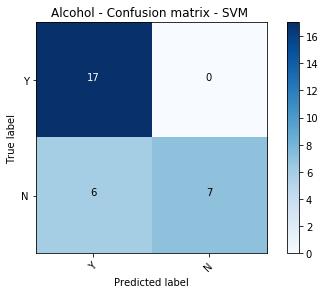

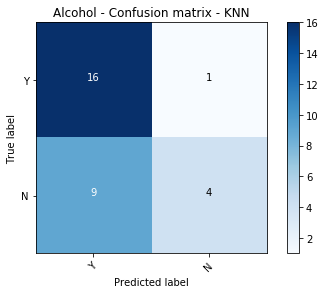

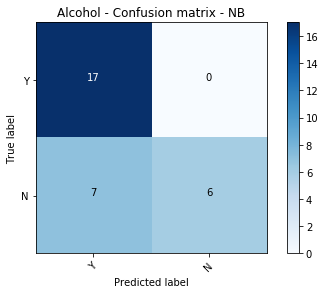

In [20]:
c11 = confusion_matrix(svmy1,svmp1)
c21 = confusion_matrix(knny1,knnp1)
c31 = confusion_matrix(nby1,nbp1)
class_names = ['Y', 'N']
plt.figure()
plot_confusion_matrix(c11, classes=class_names,normalize=False,title='Alcohol - Confusion matrix - SVM ')
plt.figure()
plot_confusion_matrix(c21, classes=class_names,normalize=False,title='Alcohol - Confusion matrix - KNN')
plt.figure()
plot_confusion_matrix(c31, classes=class_names,normalize=False,title='Alcohol - Confusion matrix - NB')

## Drug use case

In [21]:
selectlist2 =[ 'NOTE' , 'Current Drug Use']
selectlist2 =[x for x in df.columns if x in selectlist2]
drug = df[selectlist2]

drug

,NOTE,Current Drug Use
0,ogressNote SubjectivePatient IDfemaleChief Com...,1
1,ogressNote SubjectivePatient IDfemaleChief Com...,1
3,HistoryChief ComplaintPatientArm Pain rightatr...,1
4,ogressNote SubjectivePatient IDfemaleChief Com...,1
9,Progress Note SubjectivePatient IDfemaleChief ...,1
...,...,...
1189,DEPARTMENTEMERGENCYPATIENTNAMEMRNDOBddd aaaax ...,0
1190,DEPARTMENTEMERGENCYPATIENTNAMEMRNDOBddd aaaax ...,0
1200,HistoryChief ComplaintPatientLeg SwellingPatie...,1
1204,HistoryChief ComplaintPatientAutomobilePedestr...,1


In [22]:
note_len_df = df.sort_values(by='Note Length')
plt4 = go.Scatter(x = note_len_df['Note Length'], y = df['Current Drug Use'], mode='markers')
lyt4 = go.Layout(title="Notes Length vs. Current Drug Use", xaxis=dict(title='Notes Length'),yaxis=dict(title='Current Drug Use'))
fig4 = go.Figure(data=[plt4], layout=lyt4)
iplot(fig4)
print("Notes Length to Current Drug Use Correlation:", note_len_df['Note Length'].corr(df['Current Drug Use']))

Notes Length to Current Drug Use Correlation: -0.19413001039076783


In [123]:
x1 = drug['NOTE']
vect = TfidfVectorizer(ngram_range = (1,2))
x_vect1 = vect.fit_transform(x1)

y2 = drug['Current Drug Use']
y2

0       1
1       1
3       1
4       1
9       1
       ..
1189    0
1190    0
1200    1
1204    1
1247    1
Name: Current Drug Use, Length: 119, dtype: int32

In [115]:
svmy2,svmp2 = linsvc(x_vect1,y2)
knny2,knnp2 = revknn(x_vect1,y2)
nby2,nbp2 = revnb(x_vect1,y2)

Linear SVC: 0.6666666666666666
kNN: 0.7333333333333333
Naive Bayes: 0.6666666666666666


Confusion matrix, without normalization
[[ 3  8]
 [ 2 17]]
Confusion matrix, without normalization
[[ 7  4]
 [ 4 15]]
Confusion matrix, without normalization
[[ 2  9]
 [ 1 18]]


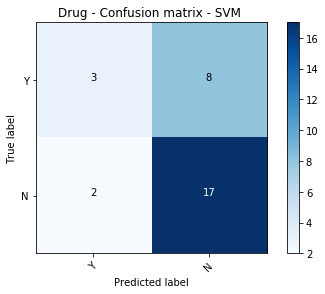

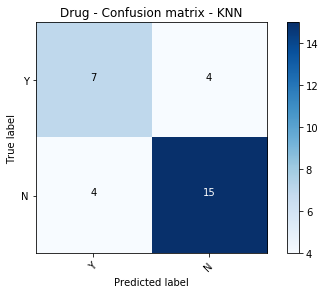

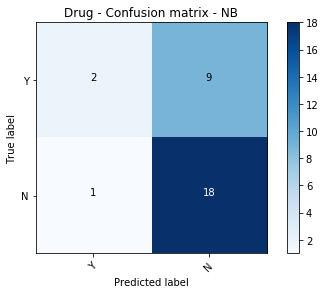

In [116]:
c12 = confusion_matrix(svmy2,svmp2)
c22 = confusion_matrix(knny2,knnp2)
c32 = confusion_matrix(nby2,nbp2)
class_names = ['Y', 'N']
plt.figure()
plot_confusion_matrix(c12, classes=class_names,normalize=False,title='Drug - Confusion matrix - SVM ')
plt.figure()
plot_confusion_matrix(c22, classes=class_names,normalize=False,title='Drug - Confusion matrix - KNN')
plt.figure()
plot_confusion_matrix(c32, classes=class_names,normalize=False,title='Drug - Confusion matrix - NB')

## Current Smoker

In [23]:
selectlist3 =[ 'NOTE' , 'Current Smoker']
selectlist3 =[x for x in df.columns if x in selectlist3]
smoker = df[selectlist3]

smoker

,NOTE,Current Smoker
0,ogressNote SubjectivePatient IDfemaleChief Com...,1
1,ogressNote SubjectivePatient IDfemaleChief Com...,1
3,HistoryChief ComplaintPatientArm Pain rightatr...,1
4,ogressNote SubjectivePatient IDfemaleChief Com...,1
9,Progress Note SubjectivePatient IDfemaleChief ...,1
...,...,...
1189,DEPARTMENTEMERGENCYPATIENTNAMEMRNDOBddd aaaax ...,1
1190,DEPARTMENTEMERGENCYPATIENTNAMEMRNDOBddd aaaax ...,1
1200,HistoryChief ComplaintPatientLeg SwellingPatie...,1
1204,HistoryChief ComplaintPatientAutomobilePedestr...,1


In [24]:
note_len_df = df.sort_values(by='Note Length')
plt5 = go.Scatter(x = note_len_df['Note Length'], y = df['Current Smoker'], mode='markers')
lyt5 = go.Layout(title="Notes Length vs. Current Smoker", xaxis=dict(title='Notes Length'),yaxis=dict(title='Current Smoker'))
fig5 = go.Figure(data=[plt5], layout=lyt5)
iplot(fig5)
print("Notes Length to Current Smoker Correlation:", note_len_df['Note Length'].corr(df['Current Smoker']))

Notes Length to Current Smoker Correlation: 0.32362907686812464


In [122]:
x1 = smoker['NOTE']
vect = TfidfVectorizer(ngram_range = (1,2))
x_vect1 = vect.fit_transform(x1)

y3 = smoker['Current Smoker']
y3

0       1
1       1
3       1
4       1
9       1
       ..
1189    1
1190    1
1200    1
1204    1
1247    0
Name: Current Smoker, Length: 119, dtype: int32

In [127]:
svmy3,svmp3 = linsvc(x_vect1,y3)
knny3,knnp3 = revknn(x_vect1,y3)
nby3,nbp3 = revnb(x_vect1,y3)

Linear SVC: 0.9666666666666667
kNN: 0.9333333333333333
Naive Bayes: 0.9


Confusion matrix, without normalization
[[17  1]
 [ 6  6]]
Confusion matrix, without normalization
[[16  2]
 [ 9  3]]
Confusion matrix, without normalization
[[17  1]
 [ 9  3]]


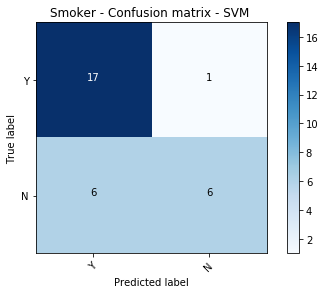

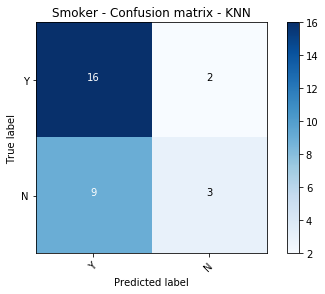

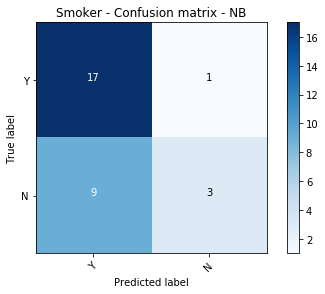

In [128]:
c13 = confusion_matrix(svmy3,svmp3)
c23 = confusion_matrix(knny3,knnp3)
c33 = confusion_matrix(nby3,nbp3)
class_names = ['Y', 'N']
plt.figure()
plot_confusion_matrix(c1, classes=class_names,normalize=False,title='Smoker - Confusion matrix - SVM ')
plt.figure()
plot_confusion_matrix(c2, classes=class_names,normalize=False,title='Smoker - Confusion matrix - KNN')
plt.figure()
plot_confusion_matrix(c3, classes=class_names,normalize=False,title='Smoker - Confusion matrix - NB')